In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


2024-09-14 23:14:41.683373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 23:14:41.683756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 23:14:41.685654: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 23:14:41.691334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 23:14:41.700783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
data = pd.read_csv('data/features_cleaned.csv')
data.head()

,close,high,low,num_trades,total_btc_volume,total_usd_volume
0,60138.15,60138.15,60138.14,13.0,0.09273,5576.609800
1,60138.14,60138.15,60138.14,45.0,0.44425,26716.369142
2,60138.15,60138.15,60138.14,77.0,0.76544,46032.138895
3,60138.14,60138.15,60138.14,95.0,1.02535,61662.644172
4,60138.04,60138.15,60138.04,139.0,2.64337,158967.216828


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaled_y = scaler_y.fit_transform(data['close'].values.reshape(-1, 1))

features_to_scale = data[['close', 'high', 'low', 'total_btc_volume', 'total_usd_volume', 'num_trades']]
features_to_scale = np.array(features_to_scale).reshape(-1, 6)

scaled_features = scaler_x.fit_transform(features_to_scale)
scaled_features


array([[9.67124045e-01, 9.66943220e-01, 9.78127412e-01, 8.84304026e-04,
        8.89015336e-04, 2.65604250e-03],
       [9.67105627e-01, 9.66943220e-01, 9.78127412e-01, 4.29911839e-03,
        4.32177962e-03, 1.11553785e-02],
       [9.67124045e-01, 9.66943220e-01, 9.78127412e-01, 7.41929426e-03,
        7.45835669e-03, 1.96547145e-02],
       ...,
       [3.47877337e-01, 3.44290529e-01, 3.34577069e-01, 1.93412241e-02,
        1.93304534e-02, 1.65205843e-01],
       [3.47877337e-01, 3.44290529e-01, 3.34577069e-01, 1.40821263e-02,
        1.40742321e-02, 1.04648074e-01],
       [3.47877337e-01, 3.44290529e-01, 3.45605264e-01, 2.15067635e-03,
        2.14962776e-03, 5.28552457e-02]])

In [4]:
x = []
y = []

for i in range(100, len(scaled_features)):
    x.append(scaled_features[i-100:i])
    y.append(scaled_features[i, 0])
    
train_size = int(len(x) * 0.8)
test_size = len(x) - train_size

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [5]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

x_test, y_test = np.array(x_test), np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))


In [6]:
from keras._tf_keras.keras.models import  Model
from keras._tf_keras.keras.layers import LSTM, Add, Concatenate, Input, Attention, Dense, Flatten

inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

# LSTM layer 1
lstm_out_1 = LSTM(50, return_sequences=True)(inputs)

# LSTM layer 2
lstm_out_2 = LSTM(50, return_sequences=True)(lstm_out_1)

# LSTM layer 3
lstm_out_3 = LSTM(50, return_sequences=True)(lstm_out_2)

# Attention mechanism
attention = Attention()([lstm_out_1, lstm_out_2])

# Flatten outputs for concatenation
lstm_out_3_flat = Flatten()(lstm_out_3)
attention_flat = Flatten()(attention)

# Combine LSTM output with attention output
concat = Concatenate(axis=-1)([lstm_out_3_flat, attention_flat])
dense_out = Dense(1)(concat)

model = Model(inputs=inputs, outputs=dense_out)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Dự đoán
y_pred = model.predict(x_test)
y_pred

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.1015 - val_loss: 0.0037
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0087 - val_loss: 0.0049
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0029 - val_loss: 0.0053
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0

array([[ 0.16541371],
       [ 0.15811138],
       [ 0.15103796],
       [ 0.145803  ],
       [ 0.14191249],
       [ 0.13777949],
       [ 0.13288194],
       [ 0.12644497],
       [ 0.11792244],
       [ 0.10743871],
       [ 0.09491526],
       [ 0.08194317],
       [ 0.06949241],
       [ 0.05861276],
       [ 0.04962971],
       [ 0.04265343],
       [ 0.03746123],
       [ 0.03369897],
       [ 0.0315724 ],
       [ 0.03112941],
       [ 0.03228361],
       [ 0.03456466],
       [ 0.0382361 ],
       [ 0.03860525],
       [ 0.0383422 ],
       [ 0.0390466 ],
       [ 0.04548715],
       [ 0.05282576],
       [ 0.06080479],
       [ 0.06830084],
       [ 0.07729442],
       [ 0.08481276],
       [ 0.09026155],
       [ 0.09229577],
       [ 0.09175617],
       [ 0.08817055],
       [ 0.08212538],
       [ 0.07372168],
       [ 0.06377346],
       [ 0.05362862],
       [ 0.04330851],
       [ 0.0334544 ],
       [ 0.02259946],
       [ 0.01147828],
       [ 0.00064611],
       [-0

<Axes: >

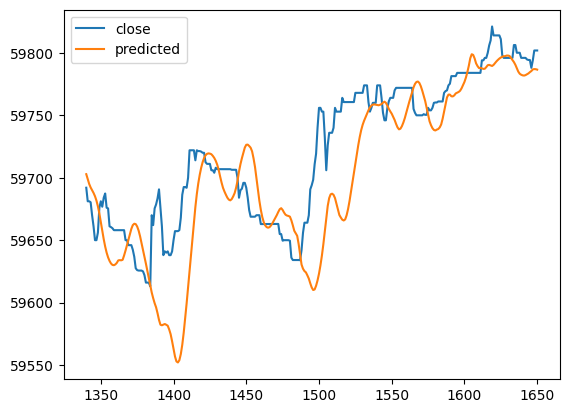

In [10]:
origin_predicted = scaler_y.inverse_transform(np.array(y_pred).reshape(-1, 1))
df = pd.DataFrame(origin_predicted)
df2 = pd.DataFrame(data["close"][train_size+100:])
df2["predicted"] = df[0].values
df2.plot()

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


<Axes: >

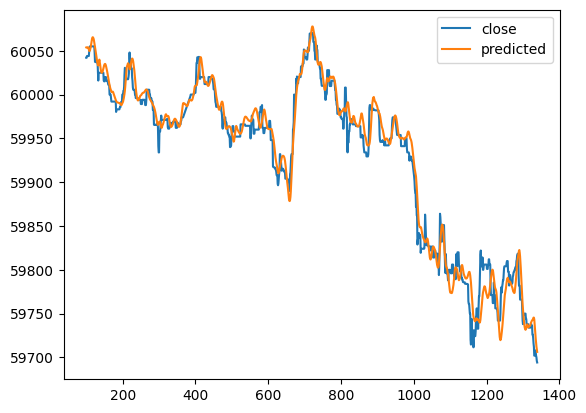

In [11]:
predicted = model.predict(x_train)
predicted = scaler_y.inverse_transform(np.array(predicted).reshape(-1, 1))
df = pd.DataFrame(predicted)
df3 = pd.DataFrame(data["close"][100:train_size+100])
df3["predicted"] = df[0].values
df3.plot()

In [13]:
model.save('btc_lstm.keras')

In [14]:
import joblib

joblib.dump(scaler_x, 'scaler_x.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']